In [1]:
import shap
import numpy as np 
import pandas as pd 
import seaborn as sns 
from copy import deepcopy
import joblib 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import train_test_split


***1. Reading Dataset***

In [2]:
pollination = pd.read_csv("PatatoData.csv")


In [3]:
 pollination.shape

(777, 18)

***2. EDA***

In [4]:
pollination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  vegetset              777 non-null    float64
 15  vegetmass             7

Всего у нас есть 17 столбцов в наборе данных, 16 столбцов являются независимыми переменными, а 1 ("yield") является целевой переменной (зависимой).
Каждый столбец имеет 777 строк (экземпляров).
Все столбцы имеют числовой тип данных (int64,float64).

In [5]:
pollination.describe()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,vegetset,vegetmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,388.000000,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,224.444871,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,194.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,388.000000,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,582.000000,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,776.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


In [6]:
# Проверка наличия нулевых значений.
pollination.isnull().sum()

Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
vegetset                0
vegetmass               0
seeds                   0
yield                   0
dtype: int64

In [7]:
X = pollination.drop('yield',axis=1)
y = pollination['yield']
print("Shape of Indenpendent variables: ",X.shape)
print("Shape of dependent variables: ",y.shape)

Shape of Indenpendent variables:  (777, 17)
Shape of dependent variables:  (777,)


In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f"Shape of training predictor column data: {X_train.shape}")
print(f"Shape of training target column data: {y_train.shape}")
print(f"Shape of testing predictor column data: {X_test.shape}")
print(f"Shape of testing target column data: {y_test.shape}")

Shape of training predictor column data: (621, 17)
Shape of training target column data: (621,)
Shape of testing predictor column data: (156, 17)
Shape of testing target column data: (156,)


In [57]:
global results
results = pd.DataFrame(columns=['model','MAE','MSE','RMSE','R-squared'])



def scores(predicted,testing):
    mae = mean_absolute_error(testing, predicted)
    mse = mean_squared_error(testing, predicted)
    rmse = np.sqrt(mse)
    
    print('MAE: %.3f' % mae)
    print('RMSE: %.3f' % rmse)
    



In [58]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

print
scores(lr_pred,y_test)


MAE: 99.416
RMSE: 133.488


In [59]:
xgboost = XGBRegressor()
xgboost.fit(X_train,y_train)
xgPred = xgboost.predict(X_test)
scores(xgPred,y_test)

MAE: 109.950
RMSE: 143.671


In [60]:
import joblib 
joblib.dump(xgboost,'xgb.pkl')

['xgb.pkl']

***2.EDA***


<Figure size 1200x2400 with 0 Axes>

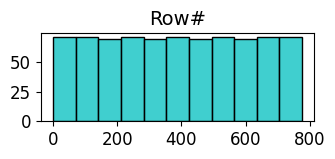

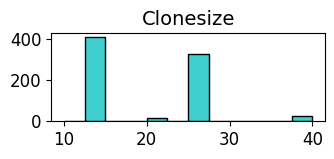

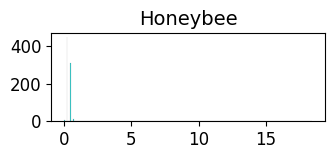

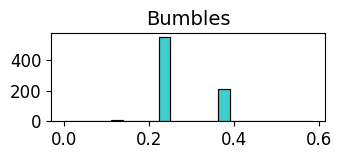

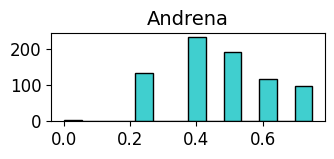

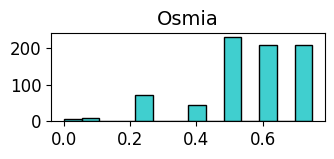

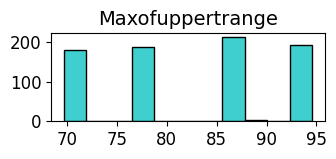

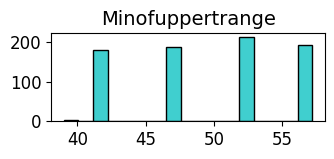

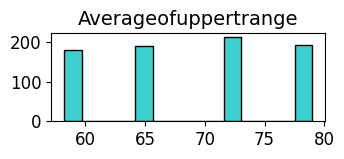

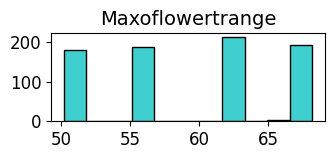

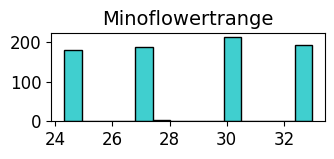

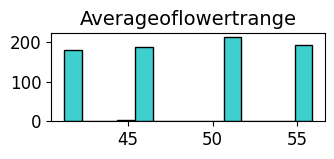

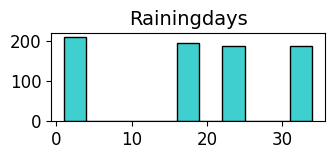

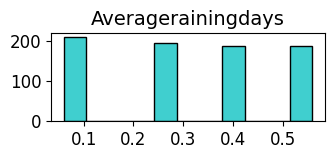

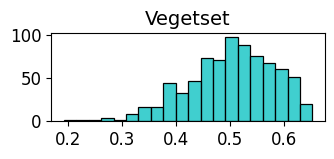

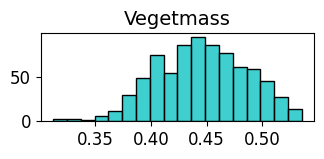

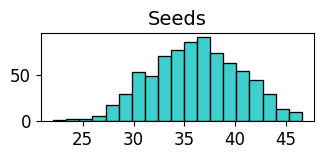

In [61]:
plt.figure(figsize=(12,24))
counter = 1 
for col in pollination.columns[:-1]: 
    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(6,3,counter)
    sns.histplot(pollination[col],color='c')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(col.title(), fontsize=14)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()
    counter += 1 

In [62]:
#Поищем выбросы

<Figure size 1200x2400 with 0 Axes>

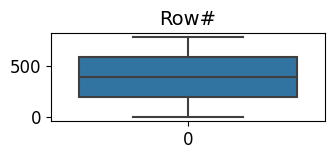

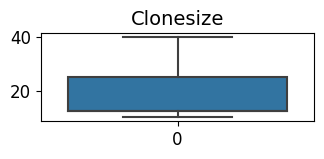

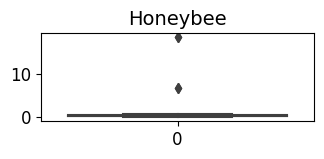

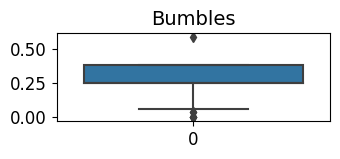

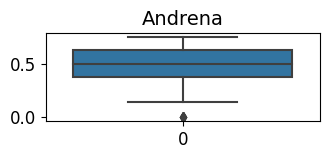

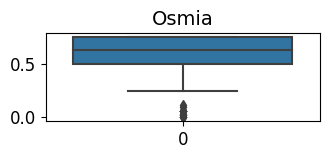

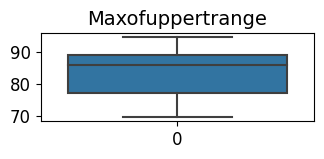

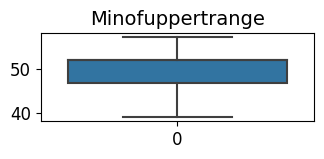

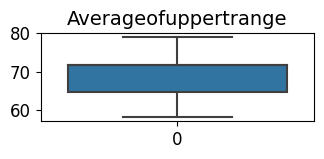

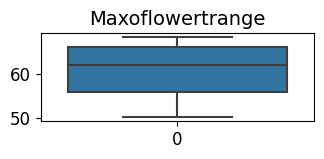

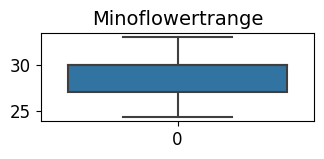

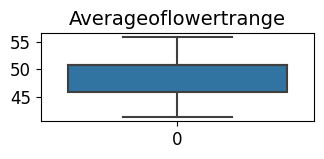

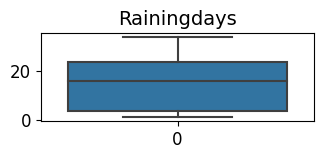

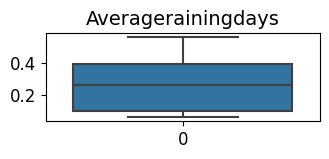

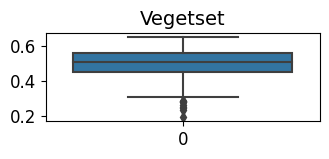

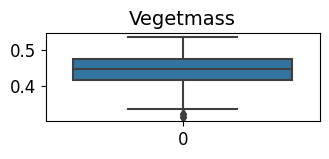

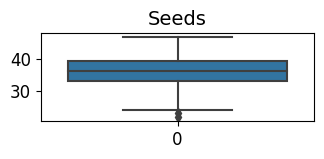

In [63]:
plt.figure(figsize=(12,24))
counter = 1 
for col in pollination.columns[:-1]: 
    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(6,3,counter)
    sns.boxplot(pollination[col])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(col.title(), fontsize=14)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()
    counter += 1 

1. Из приведенных выше визуализаций мы можем наблюдать, что для нескольких графиков значения присутствуют за пределами прямоугольного графика.
2. Столбцы с выбросами: seeds, vegetmass,vegetset,Honeybee,osmia,Andrena, Bumbles 

In [64]:
# Чтобы обработать выбросы, попробую межквартильные операции.
# Межквартильный размах — мера вариативности одномерного распределения случайной величины. Одна из ключевых характеристик,
# использующихся при описании распределения, несмотря на относительно произвольно выбранную характеристику. Определяется 
# через квантили, а именно принимается равной разнице между 75-м и 25-м процентилями, то есть между третьим и первым квартилями.
# IQR: Q3-Q1 ==> (75% квартиль - 25% квартиль)

In [65]:
Q1 = pollination.quantile(0.25)
Q3 = pollination.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Row#                     388.000000
clonesize                 12.500000
honeybee                   0.250000
bumbles                    0.130000
andrena                    0.250000
osmia                      0.250000
MaxOfUpperTRange          11.600000
MinOfUpperTRange           5.200000
AverageOfUpperTRange       7.200000
MaxOfLowerTRange          10.200000
MinOfLowerTRange           3.000000
AverageOfLowerTRange       5.000000
RainingDays               20.230000
AverageRainingDays         0.290000
vegetset                   0.106571
vegetmass                  0.059869
seeds                      6.123577
yield                   1897.334830
dtype: float64


In [66]:
processedPollination = pollination[~((pollination < (Q1 - 1.5 * IQR)) |(pollination > (Q3 + 1.5 * IQR))).any(axis=1)]
processedPollination.describe()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,vegetset,vegetmass,seeds,yield
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,382.337766,18.583777,0.356383,0.286649,0.475000,0.576463,82.076729,49.617154,68.577527,59.159840,28.628059,48.514362,18.484043,0.323564,0.506071,0.448129,36.359835,6079.902114
std,217.501250,6.885425,0.129602,0.058530,0.156807,0.149782,9.254791,5.610176,7.731659,6.687814,3.232915,5.454360,12.064176,0.168673,0.074723,0.038301,4.149800,1297.671790
min,0.000000,12.500000,0.250000,0.250000,0.250000,0.250000,69.700000,42.100000,58.200000,50.200000,24.300000,41.200000,1.000000,0.100000,0.308856,0.358821,27.190651,2825.003738
25%,194.750000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,1.000000,0.100000,0.458961,0.418833,33.312121,5203.052234
50%,382.500000,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.509858,0.447567,36.310639,6153.369070
75%,570.250000,25.000000,0.500000,0.380000,0.630000,0.750000,88.150000,53.300000,73.675000,63.550000,30.750000,52.075000,24.000000,0.390000,0.564822,0.476859,39.368775,7052.695481
max,758.000000,37.500000,0.750000,0.380000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.369344,8969.401842


<Figure size 1200x2400 with 0 Axes>

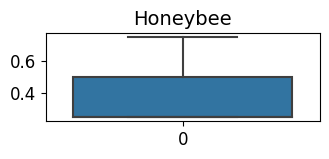

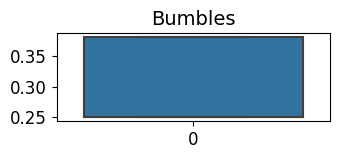

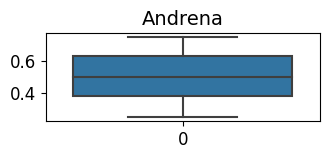

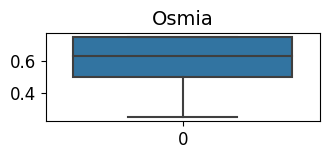

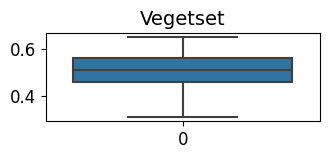

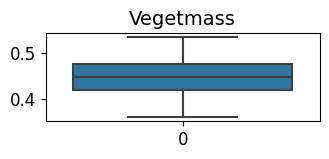

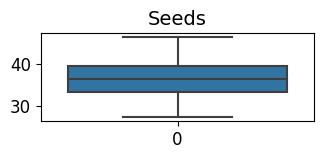

In [67]:
plt.figure(figsize=(12,24))
counter = 1 
for col in ['honeybee','bumbles','andrena','osmia','vegetset','vegetmass','seeds']: 
    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(6,3,counter)
    sns.boxplot(processedPollination[col])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(col.title(), fontsize=14)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()
    counter += 1 

In [68]:
# я могу удалить столбцы Row, так как они нам не понадобятся (поскольку они имеют только значения, такие же, как индекс)
processedPollination.drop("Row#",axis=1,inplace=True)
processedPollination.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,vegetset,vegetmass,seeds,yield
0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [69]:
# корреляция
processedPollination.corr()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,vegetset,vegetmass,seeds,yield
clonesize,1.000000,0.849859,0.036613,0.026053,-0.100149,0.008441,0.008498,0.008575,0.008494,0.008472,0.008484,-0.036500,-0.038758,-0.543512,-0.459179,-0.484549,-0.497965
honeybee,0.849859,1.000000,0.112885,0.197218,0.128819,0.004620,0.004629,0.004648,0.004628,0.004625,0.004617,-0.004874,-0.005336,-0.418614,-0.364690,-0.383849,-0.361844
bumbles,0.036613,0.112885,1.000000,-0.068276,0.160133,0.010844,0.010840,0.010850,0.010841,0.010842,0.010820,0.003771,0.004286,0.240464,0.269165,0.291045,0.255970
andrena,0.026053,0.197218,-0.068276,1.000000,0.353502,-0.000509,-0.000537,-0.000577,-0.000535,-0.000524,-0.000526,0.020708,0.022242,0.063321,0.032298,0.029017,0.101106
osmia,-0.100149,0.128819,0.160133,0.353502,1.000000,-0.015780,-0.015834,-0.015933,-0.015830,-0.015810,-0.015785,0.036872,0.039080,0.280458,0.254137,0.272781,0.327029
MaxOfUpperTRange,0.008441,0.004620,0.010844,-0.000509,-0.015780,1.000000,0.999998,0.999988,0.999998,0.999999,0.999988,-0.004529,-0.004532,-0.095093,0.107051,0.007113,-0.156796
MinOfUpperTRange,0.008498,0.004629,0.010840,-0.000537,-0.015834,0.999998,1.000000,0.999994,1.000000,0.999999,0.999992,-0.004514,-0.004515,-0.094342,0.108109,0.007997,-0.156173
AverageOfUpperTRange,0.008575,0.004648,0.010850,-0.000577,-0.015933,0.999988,0.999994,1.000000,0.999994,0.999992,0.999979,-0.004476,-0.004475,-0.093565,0.109162,0.008903,-0.155534
MaxOfLowerTRange,0.008494,0.004628,0.010841,-0.000535,-0.015830,0.999998,1.000000,0.999994,1.000000,1.000000,0.999992,-0.004515,-0.004517,-0.094397,0.108032,0.007933,-0.156219
MinOfLowerTRange,0.008472,0.004625,0.010842,-0.000524,-0.015810,0.999999,0.999999,0.999992,1.000000,1.000000,0.999991,-0.004521,-0.004523,-0.094682,0.107631,0.007598,-0.156455


<Axes: >

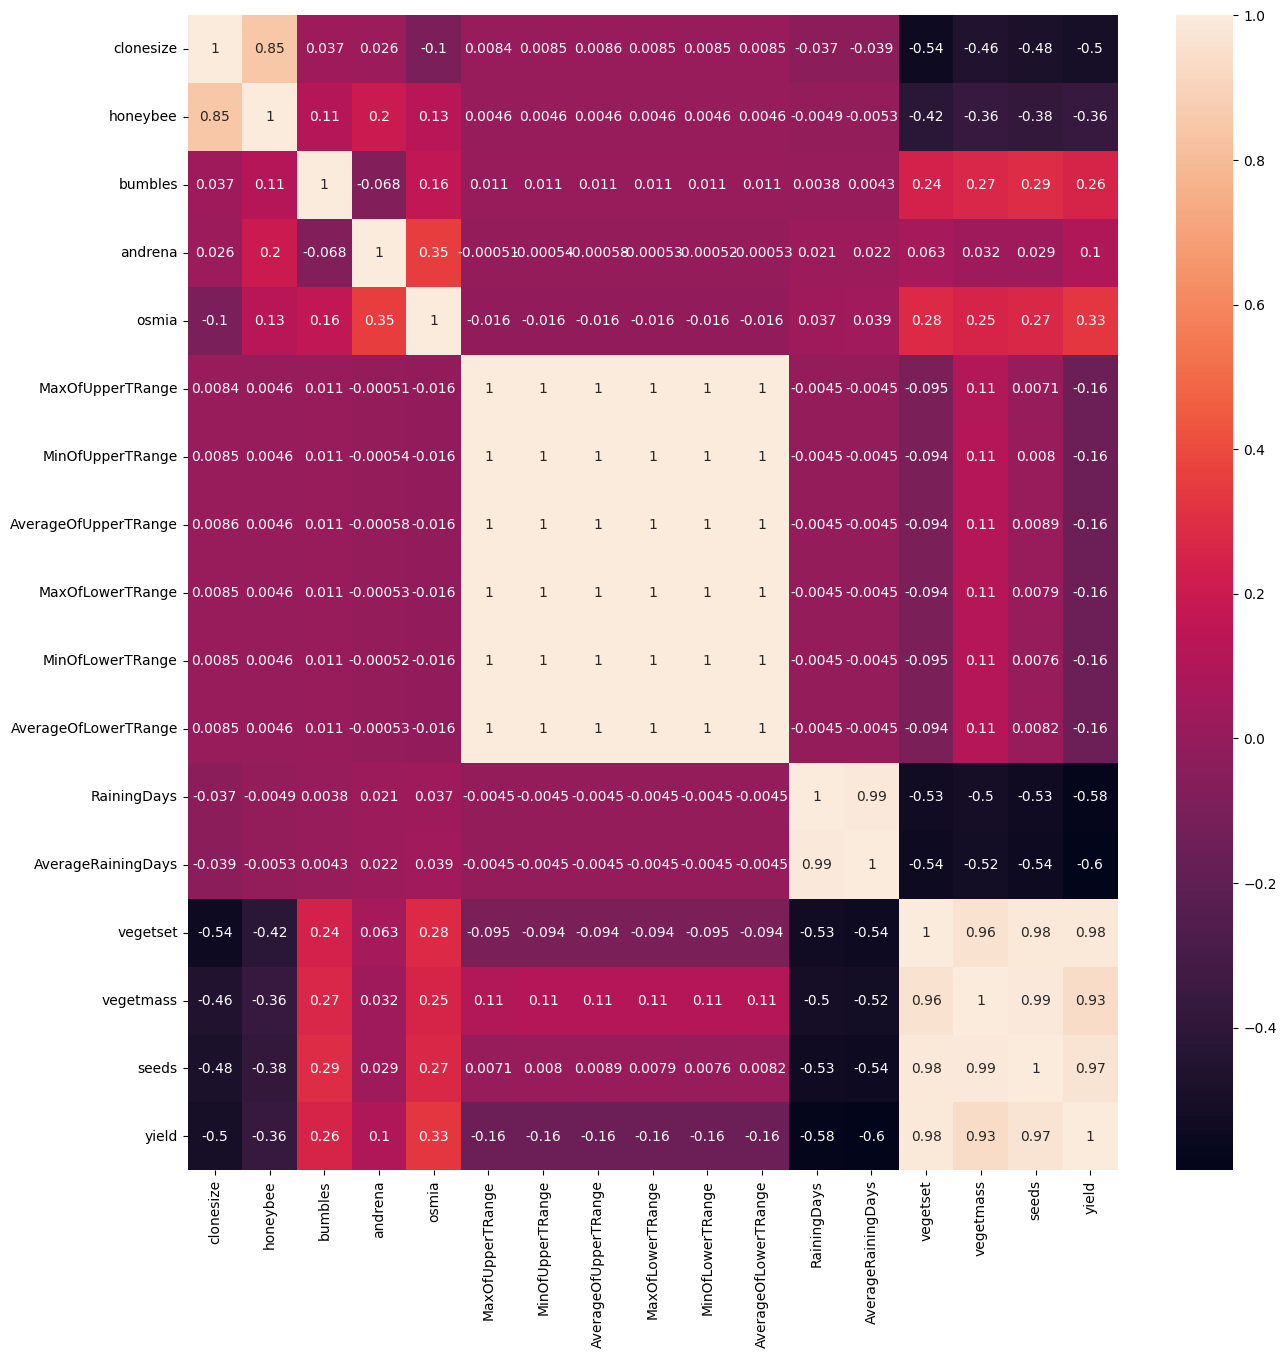

In [70]:
plt.figure(figsize=(15,15))
sns.heatmap(processedPollination.corr(),annot=True)

In [71]:
processedPollination.drop(["MaxOfUpperTRange","MinOfUpperTRange",
                          "MaxOfLowerTRange","MinOfLowerTRange"],axis=1,inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
processedPollination.shape

(752, 13)

### 3. Preprocessing

In [73]:
processedPollination.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'AverageOfUpperTRange', 'AverageOfLowerTRange', 'RainingDays',
       'AverageRainingDays', 'vegetset', 'vegetmass', 'seeds', 'yield'],
      dtype='object')

In [74]:

X1 = processedPollination.drop('yield',axis=1)
y1 = processedPollination['yield']

X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.23,random_state=21)
print("Shape of predictor training data: ",X1_train.shape)
print("Shape of predictor testing data: ",X1_test.shape)
print("Shape of Target training data: ",y1_train.shape)
print("Shape of Target testing data: ",y1_test.shape)


Shape of predictor training data:  (579, 12)
Shape of predictor testing data:  (173, 12)
Shape of Target training data:  (579,)
Shape of Target testing data:  (173,)


### LinearRegression

In [75]:
lr1 = LinearRegression()
lr1.fit(X1_train,y1_train)
lr1_pred = lr1.predict(X1_test)

In [76]:
scores(y1_test,lr1_pred)

MAE: 86.495
RMSE: 108.659


In [77]:
joblib.dump(lr1,'linearReg.joblib')

['linearReg.joblib']

#### XGB model

In [78]:
xg1 = XGBRegressor()
xg1.fit(X1_train,y1_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [79]:
xg1Pred = xg1.predict(X1_test)
print(scores(y1_test,xg1Pred))

MAE: 115.556
RMSE: 145.197
None


In [80]:
joblib.dump(xg1,'xgb1.joblib')

['xgb1.joblib']

#### Additional Preprocessing

In [81]:
# мы можем посмотреть на rmse, он не изменился по сравнению с последним прогнозом двух одинаковых моделей.
# Попробуем убрать 'Средние температуры']

In [82]:
X1.drop(['AverageOfUpperTRange','AverageOfLowerTRange'],inplace=True,axis=1)

In [83]:
X2 = X1
print(X2.columns,X2.shape)

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'RainingDays',
       'AverageRainingDays', 'vegetset', 'vegetmass', 'seeds'],
      dtype='object') (752, 10)


In [84]:
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y1,test_size=0.15,random_state=42)

In [85]:
# Training again
lr2 = LinearRegression()
lr2.fit(X2_train,y2_train)
lr2_pred = lr2.predict(X2_test)

In [86]:
scores(y2_test,lr2_pred)

MAE: 90.120
RMSE: 116.187


In [87]:
joblib.dump(lr2_pred,'linearReg2.joblib')

['linearReg2.joblib']

In [88]:
# xgboost 
xg2 = XGBRegressor()
xg2.fit(X2_train,y2_train)
xg2Pred = xg2.predict(X2_test)


In [89]:
scores(xg2Pred,y2_test)

MAE: 99.874
RMSE: 128.292


In [90]:
joblib.dump(xg2,'xgb2.joblib')

['xgb2.joblib']

In [91]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=1)


rf_model.fit(X2_train, y2_train)
pred_rf=rf_model.predict(X2_test)



In [92]:
scores(pred_rf,y2_test)

MAE: 104.140
RMSE: 132.095


In [93]:
joblib.dump(rf_model,'rf.joblib')

['rf.joblib']

In [95]:

print("XG1_model")
xg1_model = scores(y1_test,xg1Pred)
print("\n\n")
print("lr2_model")
lr2_model = scores(y2_test,lr2_pred)
print("\n\n")
print("xg2_model")
xg2_model = scores(xg2Pred,y2_test)
print("\n\n")
print("rf_model")
rf_model = scores(pred_rf,y2_test)
print("\n\n")
print("last_model")
print("\n")
lr1_model = scores(y1_test,lr1_pred)

XG1_model
MAE: 115.556
RMSE: 145.197



lr2_model
MAE: 90.120
RMSE: 116.187



xg2_model
MAE: 99.874
RMSE: 128.292



rf_model
MAE: 104.140
RMSE: 132.095



last_model


MAE: 86.495
RMSE: 108.659
